In [1]:
import Basic_Risk_Assessment_Tools as brat

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
%matplotlib inline
import copy
import math

In [4]:
import ipywidgets as widgets

In [5]:
from nsetools import Nse
from nsepy import get_history

As we studied in the file $Liability Hedging Portfolio$ it is likely that we won't find the exact duration $zero$ $coupon$ $bonds$ that matches the $liability$ $payment$ $schedule$.

This notebook is dedicated to trying to find this right combination of $zero$ $coupon$ $bonds$ that will meet our schedule.

For this purpose we will first start with pricing a bond, which is nothing but the Present Value of a series of cash flows that an issuer is offering to make. Therefore, we can use the "present_value" function from the $Basic Risk Assessment Tools$.

In [12]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment
    return cash_flows
    
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return brat.present_value(cash_flows, discount_rate/coupons_per_year)

In [10]:
bond_cash_flows(maturity=5, coupon_rate=0.04, coupons_per_year=2)

1       2.0
2       2.0
3       2.0
4       2.0
5       2.0
6       2.0
7       2.0
8       2.0
9       2.0
10    102.0
dtype: float64

In [17]:
bond_price(maturity=5, coupon_rate=0.04, coupons_per_year=2, discount_rate=0.049)

96.05137617468696

Notice how the cost of a bond paying a coupon rate less than the discount rate is lower than the Principal amount. If you vary the coupon_rate to values greater than the discount_rate then you'll notice that you need to pay a premium on top of the principal to buy the Bonds, in order to avail the higher returns.

In [20]:
bond_price(maturity=5, coupon_rate=0.06, coupons_per_year=2, discount_rate=0.049)

104.82609578649378

## Bond prices change with interest rates

Consider the following chart that shows the change in value of a bond for interest rates from 1% to 10%. The bond in question is a 10 year bond that pays a 5% coupon semiannually and the face value is $1000.

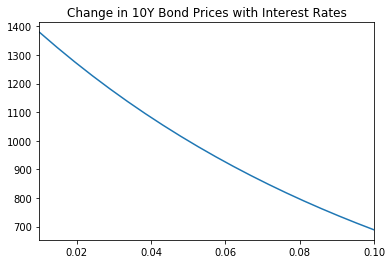

In [21]:
rates = np.linspace(.01, .10, num=20)
prices = [brat.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(title="Change in 10Y Bond Prices with Interest Rates", legend=False)

#### This shows that the price of a bond falls as the interest rates rise.

Assume that we have a liability of \$1000 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall. If we had a Zero Coupon bond, we could purchase that, but Zero Coupon bonds of specific maturities arent always available.

What is available are various bonds with maturities from 5 to 30 years. To build a portfolio that has the same sensitivity to interest rates as our liabilities do we employ $Duration Matching$. The duration of a bond measures its senstivity to interest rate changes. Therefore, we match the duration of the liabilities to the duration of the bond portfolio.

For a $zero$ $coupon$ $bonds$ the payment is received on maturity. But for all $nonzero$ $coupon$ $bonds$ the payment is received at a point less than the maturity because of the intermediate coupon payments, which repay the money that we are owed through the maturity of the bond. 

This value is known as the $Macaulay$ $Duration$ and is the weighted average of the time of cash flows, weighted by the present value of the cash flows.

In [25]:
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = brat.discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)

In [28]:
brat.bond_cash_flows(maturity=5, coupon_rate=0.04, coupons_per_year=2)

1       2.0
2       2.0
3       2.0
4       2.0
5       2.0
6       2.0
7       2.0
8       2.0
9       2.0
10    102.0
dtype: float64

In [30]:
macaulay_duration(brat.bond_cash_flows(maturity=5, coupon_rate=0.04, coupons_per_year=2), discount_rate=0.049/2)

9.141361083067762

# Duration Matching

In [75]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])
brat.macaulay_duration(liabilities, 0.04)

10.960799385088393

Let us assume we have two types of bonds available. We have a 10 year bond and a 15 year bond. Each of them pays a 5% coupon once a year and has a face value of \\$1000. 

The durations of these bonds is.....

In [68]:
shortd_bond = brat.bond_cash_flows(10, 1000, .05, 1)
md_shortd = brat.macaulay_duration(shortd_bond, .04)
md_shortd

8.190898824083233

In [69]:
longd_bond = brat.bond_cash_flows(20, 1000, .05, 1)
md_longd = brat.macaulay_duration(longd_bond, .04)
md_longd

13.544718122145921

We need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, 

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In [70]:
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)

In [71]:
# update the funding_ratio function to get present value of assets

def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return present_value(assets, r)/present_value(liabilities, r)

In [72]:
w_short = match_durations(liabilities, shortd_bond, longd_bond, 0.04)
w_short

0.48263092069478974

In [76]:
p_short = brat.bond_price(10, 1000, .05, 1, 0.04)
p_long = brat.bond_price(20, 1000, .05, 1, 0.04)
a_0 = 130000
cf_shortd = a_0*w_short*shortd_bond/p_short
cf_longd = a_0*(1-w_short)*longd_bond/p_long
cf_assets=pd.concat([cf_shortd, cf_longd])
brat.macaulay_duration(cf_assets, 0.04)

10.960799385088393

This matches with the duration of our Liabilities.

Let us now check the funding ratio by adding the present value of the future asset incomes.

In [77]:
brat.funding_ratio(cf_assets, liabilities, 0.04)

0.9998760012192478

Good news is that we are ever so slightly $underfunded$.

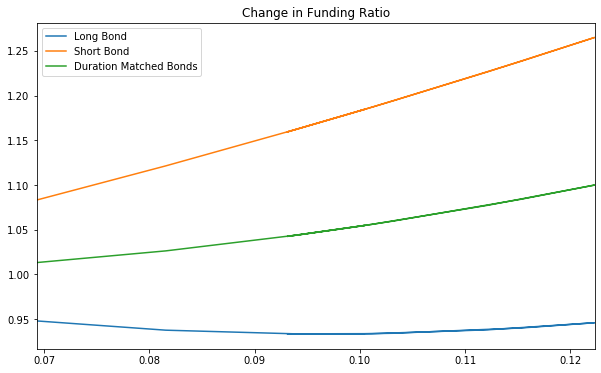

In [81]:
rates = list(brat.cir(n_years=11, n_scenarios=1, a=0.1, sigma=0.02287738471, r_0=0.10, b=0.0814, steps_per_year=1)[0][0])
cf_full_longd =  a_0*longd_bond/p_long
cf_full_shortd = a_0*shortd_bond/p_short
fr_change = pd.DataFrame({
    "Long Bond":[brat.funding_ratio(cf_full_longd, liabilities, r) for r in rates],
    "Short Bond":[brat.funding_ratio(cf_full_shortd, liabilities, r) for r in rates],
    "Duration Matched Bonds":[brat.funding_ratio(cf_assets, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio', figsize=(10,6))

## Conclusion

If we have the assets on hand, we can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize ourselves against level shifts in the yield curve. 

In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.